In [1]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
import csv
from torch import nn
from sklearn.utils import class_weight
import numpy as np
from sklearn import metrics
import matplotlib.pyplot as plt

torch.manual_seed(0)

DATA_PATH = '/home/skrhakv/deeplife/deeplife-project/data'
ESM_EMBEDDINGS_PATH = '/home/skrhakv/esm2/embeddings-3B-deeplife'
PROTBERT_EMBEDDINGS_PATH = '/home/skrhakv/protbert/embeddings-deeplife'
MODELS_PATH = '/home/skrhakv/deeplife/deeplife-project/models'

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Train a classifier on HOLO sequence and evaluate on APO vs. HOLO sequences

### Load the dataset

In [30]:
class SequenceCryptoBenchDataset(Dataset):
    def __init__(self, _Xs, _Ys):
        _Xs_list = []
        _Ys_list = []
        for key, _ in _Xs.items():
            print(f'Processing {key} ...')
            _Xs_list.append(_Xs[key])
            _Ys_list.append(_Ys[key])

        print('Concatenating ...')
        Xs_list = np.concatenate(_Xs_list, axis=0)
        Ys_list = np.concatenate(_Ys_list, axis=0)

        print('Converting to torch tensor ...')
        self.Xs = torch.tensor(Xs_list, dtype=torch.float32)
        self.Ys = torch.tensor(Ys_list, dtype=torch.int64)

    def __len__(self):
        assert len(self.Xs) == len(self.Ys)
        return len(self.Xs)

    def __getitem__(self, idx):
        x = self.Xs[idx]
        y = self.Ys[idx]
        return x, y

def process_sequence_dataset(annotation_path, embeddings_paths):
    Xs = {}
    Ys = {}
    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            id = row[0].lower() + row[1]
            sequence = row[4]

            if row[3] == '':
                continue
            
            # load the precomputed embedding
            if id not in Xs:
                for embeddings_path in embeddings_paths:
                    filename = id + '.npy'
                    embedding = np.load(f'{embeddings_path}/{filename}')
                    if id not in Xs:
                        Xs[id] = embedding
                    else:
                        Xs[id] = np.concatenate((Xs[id], embedding), axis = 1)
                    

            # load the annotations denoting whether particular residue is binding or not
            # we use binary annotation: 0=non-binding; 1=binding
            if id not in Ys:
                Ys[id] = np.zeros(embedding.shape[0])
            for (aa, residue_idx) in [(residue[0], int(residue[1:])) for residue in row[3].split(' ')]:
                assert sequence[residue_idx] == aa
                Ys[id][residue_idx] = 1

    return Xs, Ys

In [26]:
Xs_train_holo, Ys_train_holo = process_sequence_dataset(f'{DATA_PATH}/holo_train.txt', [ESM_EMBEDDINGS_PATH])
train_dataset_holo = SequenceCryptoBenchDataset(Xs_train_holo, Ys_train_holo)

Xs_test_holo, Ys_test_holo = process_sequence_dataset(f'{DATA_PATH}/holo_test.txt', [ESM_EMBEDDINGS_PATH])
test_dataset_holo = SequenceCryptoBenchDataset(Xs_test_holo, Ys_test_holo)

Xs_test_apo, Ys_test_apo = process_sequence_dataset(f'{DATA_PATH}/apo_test.txt', [ESM_EMBEDDINGS_PATH])
test_dataset_apo = SequenceCryptoBenchDataset(Xs_test_apo, Ys_test_apo)

In [3]:
DROPOUT = 0.3
LAYER_WIDTH = 100
ESM2_DIM = 2560
PROTBERT_DIM = 1024

class CryptoBenchClassifier(nn.Module):
    def __init__(self, input_dim=ESM2_DIM):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=input_dim, out_features=LAYER_WIDTH)
        self.dropout1 = nn.Dropout(DROPOUT)

        self.layer_2 = nn.Linear(in_features=LAYER_WIDTH, out_features=LAYER_WIDTH)
        self.dropout2 = nn.Dropout(DROPOUT)

        self.layer_3 = nn.Linear(in_features=LAYER_WIDTH, out_features=1)

        self.relu = nn.ReLU()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.dropout2(self.relu(self.layer_2(self.dropout1(self.relu(self.layer_1(x)))))))


def compute_class_weights(labels):
    class_weights=class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights=torch.tensor(class_weights,dtype=torch.float)
    return class_weights

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

torch.manual_seed(42)

def train(model, optimizer, epochs, batch_size, loss_fn, train_dataset, test_dataset):
    model = model.to(device)

    # Create an optimizer
    _, y_train = train_dataset[:]
    X_test, y_test, = test_dataset[:]

    # compute class weights (because the dataset is heavily imbalanced)
    class_weights = compute_class_weights(y_train.numpy()).to(device)
    print(f'Class weights: ', class_weights)
    # BCEWithLogitsLoss - sigmoid is already built-in!
    loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

    X_test, y_test = X_test.to(device), y_test.to(device).float()

    train_losses, test_losses = [], []

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(epochs):
        #
        # TEST
        #
        model.eval()
        with torch.inference_mode():

            test_logits = model(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))

            test_loss = loss_fn(test_logits,
                                y_test)
            test_losses.append(test_loss.cpu().detach().numpy())

            # compute metrics on test dataset
            test_acc = accuracy_fn(y_true=y_test,
                                   y_pred=test_pred)
            fpr, tpr, thresholds = metrics.roc_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
            roc_auc = metrics.auc(fpr, tpr)

            mcc = metrics.matthews_corrcoef(y_test.cpu().numpy(), test_pred.cpu().numpy())

        #
        # TRAIN
        #
        batch_losses = []
        for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):

            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device).float()

            model.train()

            y_logits = model(x_batch).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logits))

            loss = loss_fn(y_logits,
                           y_batch)
            acc = accuracy_fn(y_true=y_batch,
                              y_pred=y_pred)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            batch_losses.append(loss.cpu().detach().numpy())

        train_losses.append(sum(batch_losses) / len(batch_losses))
        #if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc}, MCC: {mcc}, sum: {sum(test_pred)}")

    plt.plot(train_losses,label="train loss over epochs")
    plt.plot(test_losses,label="test loss over epochs")
    plt.legend()
    plt.show()

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'r', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    return fpr, tpr, roc_auc


### TRAIN
Train the method on HOLO sequences, evaluate on APO and HOLO test set.

In [31]:
model_0 = CryptoBenchClassifier().to(device)
epochs = 80

# Create an optimizer
optimizer = torch.optim.Adam(params=model_0.parameters(),
                            lr=0.0001, weight_decay=5e-4)

X_train, y_train = train_dataset_holo[:]
X_test_holo, y_test_holo = test_dataset_holo[:]
X_test_apo, y_test_apo = test_dataset_apo[:]

# compute class weights (because the dataset is heavily imbalanced)
class_weights = compute_class_weights(y_train.numpy()).to(device)
print(f'Class weights: {class_weights}')

# BCEWithLogitsLoss - sigmoid is already built-in!
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

X_train, y_train = X_train.to(device), y_train.to(device).float()
X_test_holo, y_test_holo = X_test_holo.to(device), y_test_holo.to(device).float()
X_test_apo, y_test_apo = X_test_apo.to(device), y_test_apo.to(device).float()

train_losses, test_losses_holo, test_losses_apo = [], [], []

for epoch in range(epochs):

    #
    # TRAIN
    #
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits,
                   y_train)
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    train_losses.append(loss.cpu().detach().numpy())

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    #
    # TEST
    #
    model_0.eval()
    with torch.inference_mode():
        #
        # test for HOLO
        #
        test_logits = model_0(X_test_holo).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss_holo = loss_fn(test_logits,
                            y_test_holo)
        test_losses_holo.append(test_loss_holo.cpu().detach().numpy())

        # compute metrics on test dataset
        test_acc_holo = accuracy_fn(y_true=y_test_holo,
                               y_pred=test_pred)
        fpr_holo_seq, tpr_holo_seq, thresholds_holo = metrics.roc_curve(y_test_holo.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
        roc_auc_holo_seq = metrics.auc(fpr_holo_seq, tpr_holo_seq)

        mcc_holo = metrics.matthews_corrcoef(y_test_holo.cpu().numpy(), test_pred.cpu().numpy())
        
        #
        # test for APO
        #
        test_logits = model_0(X_test_apo).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss_apo = loss_fn(test_logits,
                            y_test_apo)
        test_losses_apo.append(test_loss_apo.cpu().detach().numpy())

        # compute metrics on test dataset
        test_acc_apo = accuracy_fn(y_true=y_test_apo,
                               y_pred=test_pred)
        fpr_apo_seq, tpr_apo_seq, thresholds_apo = metrics.roc_curve(y_test_apo.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
        roc_auc_apo_seq = metrics.auc(fpr_apo_seq, tpr_apo_seq)

        mcc_apo = metrics.matthews_corrcoef(y_test_apo.cpu().numpy(), test_pred.cpu().numpy())
    if epoch % 10 == 0:
        print(f"APO  - Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc_apo:.2f}% | Test loss: {test_loss_apo:.5f}, AUC: {roc_auc_apo_seq}, MCC: {mcc_apo}")
        print(f"HOLO - Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {test_acc_holo:.2f}% | Test loss: {test_loss_holo:.5f}, AUC: {roc_auc_apo_seq}, MCC: {mcc_holo}")

Class weights: tensor([ 0.5183, 14.1635], device='cuda:0')
APO  - Epoch: 0 | Loss: 1.67254, Accuracy: 75.73% | Test loss: 1.43941, AUC: 0.5054589385477037, MCC: 0.00484163410204619
HOLO - Epoch: 0 | Loss: 1.67254, Accuracy: 76.46% | Test loss: 1.14912, AUC: 0.5054589385477037, MCC: 0.0020027973374380703
APO  - Epoch: 10 | Loss: 1.08300, Accuracy: 85.99% | Test loss: 1.06685, AUC: 0.7404564991281842, MCC: 0.20299675031227418
HOLO - Epoch: 10 | Loss: 1.08300, Accuracy: 86.13% | Test loss: 0.85161, AUC: 0.7404564991281842, MCC: 0.17320485687076936
APO  - Epoch: 20 | Loss: 0.88377, Accuracy: 88.46% | Test loss: 0.98844, AUC: 0.794538395461014, MCC: 0.26665270340526154
HOLO - Epoch: 20 | Loss: 0.88377, Accuracy: 88.44% | Test loss: 0.78221, AUC: 0.794538395461014, MCC: 0.2254328324000378
APO  - Epoch: 30 | Loss: 0.79430, Accuracy: 87.64% | Test loss: 0.93029, AUC: 0.8143207083004781, MCC: 0.2925825340860154
HOLO - Epoch: 30 | Loss: 0.79430, Accuracy: 87.44% | Test loss: 0.74683, AUC: 0.8143

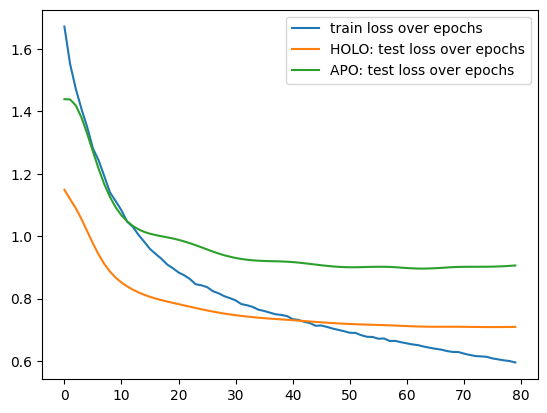

In [33]:
plt.plot(train_losses,label="train loss over epochs")
plt.plot(test_losses_holo,label="HOLO: test loss over epochs")
plt.plot(test_losses_apo,label="APO: test loss over epochs")
plt.legend()

### plot ROC curve
As you can se below, the performance for APO and HOLO is nearly identical  

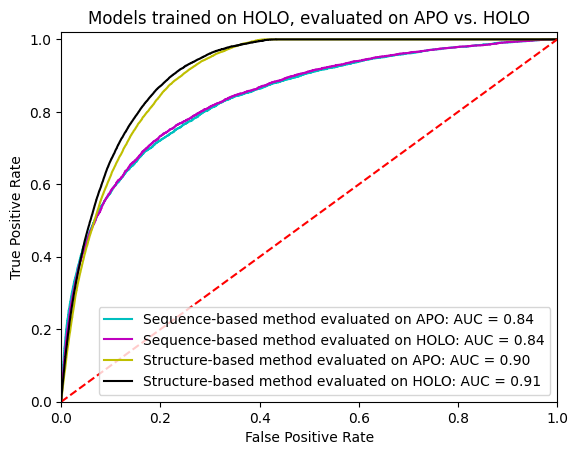

In [39]:
plt.title('Models trained on HOLO, evaluated on APO vs. HOLO')
plt.plot(fpr_apo_seq, tpr_apo_seq, 'c', label = 'Sequence-based method evaluated on APO: AUC = %0.2f' % roc_auc_apo_seq)
plt.plot(fpr_holo_seq, tpr_holo_seq, 'm', label = 'Sequence-based method evaluated on HOLO: AUC = %0.2f' % roc_auc_holo_seq)
plt.plot(fpr_apo, tpr_apo, 'y', label = 'Structure-based method evaluated on APO: AUC = %0.2f' % roc_auc_apo)
plt.plot(fpr_holo, tpr_holo, 'k', label = 'Structure-based method evaluated on HOLO: AUC = %0.2f' % roc_auc_holo)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.02])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
print(fpr_apo_seq, tpr_apo_seq)
print(fpr_holo_seq, tpr_holo_seq)

### Save the model & cleanup

In [19]:
torch.save(model_0.state_dict(), f'{MODELS_PATH}/holo_sequence_model.pth')

# TODO: delete all the 'heavy' variables to free RAM

# TRAIN STRUCTURE-BASED METHOD

In [21]:
import gc
import pickle
import os
from sklearn.metrics import confusion_matrix

HOLO_VOXEL_FEATURES_PATH = '/home/skrhakv/deeplife/deeplife-project/data/holo-voxel-features'
HOLO_VOXEL_ANNOTATIONS_PATH = '/home/skrhakv/deeplife/deeplife-project/data/holo-voxel-annotations'
APO_VOXEL_FEATURES_PATH = '/home/skrhakv/deeplife/deeplife-project/data/apo-voxel-features'
APO_VOXEL_ANNOTATIONS_PATH = '/home/skrhakv/deeplife/deeplife-project/data/apo-voxel-annotations'

WINDOW_SIZE = 16
WINDOW_STEP = 8

BATCH_SIZE = 2048

# splits the protein into 3D windows
def sliding_window_3d(vector):
    vector = vector.unfold(1,WINDOW_SIZE,WINDOW_STEP)
    vector = vector.unfold(2,WINDOW_SIZE,WINDOW_STEP)
    vector = vector.unfold(3,WINDOW_SIZE,WINDOW_STEP)
    return vector.flatten(1, 3)


def pad_and_sliding_window_3d(x, y):
    pad1 = WINDOW_SIZE - x.shape[3] % WINDOW_SIZE if WINDOW_SIZE - x.shape[3] % WINDOW_SIZE > 0 else 0
    pad2 = WINDOW_SIZE - x.shape[2] % WINDOW_SIZE if WINDOW_SIZE - x.shape[2] % WINDOW_SIZE > 0 else 0
    pad3 = WINDOW_SIZE - x.shape[1] % WINDOW_SIZE if WINDOW_SIZE - x.shape[1] % WINDOW_SIZE > 0 else 0

    x = torch.tensor(x, dtype=torch.float16)
    y = torch.tensor(y, dtype=torch.int8)

    # add padding to the voxel grid
    x = F.pad(x, (int(pad1 / 2), int(pad1 / 2) + (pad1 % 2 > 0),
        int(pad2 / 2), int(pad2 / 2) + (pad2 % 2 > 0),
        int(pad3 / 2), int(pad3 / 2) + (pad3 % 2 > 0)), mode='constant', value=0)
    y = F.pad(y, (int(pad1 / 2), int(pad1 / 2) + (pad1 % 2 > 0),
        int(pad2 / 2), int(pad2 / 2) + (pad2 % 2 > 0),
        int(pad3 / 2), int(pad3 / 2) + (pad3 % 2 > 0)), mode='constant', value=0)

    # split the protein into 3D windows
    x = sliding_window_3d(x)
    y = sliding_window_3d(y)

    return x,y

class VoxelCryptoBenchDataset(Dataset):
    def __init__(self, _Xs= None, _Ys= None):
        self.Xs = None
        self.Ys = None

        if _Xs is None or _Ys is None:
            return
        counter = 1
        keys = list(_Xs.keys())
        for key in keys:
            print(key, ' ',counter, ' / ', len(keys), ' ')
            counter += 1

            x, y = pad_and_sliding_window_3d(_Xs[key], _Ys[key])
            y = y.sum(dim=[0,2,3,4]) > 0
            if self.Xs is None:
                self.Xs = x
                self.Ys = y
            else:
                self.Xs = torch.cat((self.Xs,x),1)
                self.Ys = torch.cat((self.Ys,y))

            if counter % 5 == 0:
                gc.collect()

            del _Xs[key]
            del _Ys[key]

        self.Xs = self.Xs.swapaxes(0,1)

    def __len__(self):
        assert len(self.Xs) == len(self.Ys)
        return len(self.Xs)

    def __getitem__(self, idx):
        x = self.Xs[idx]
        y = self.Ys[idx]
        return x, y
    
class VoxelCryptoBenchCNN(nn.Module):
    def __init__(self):
        super(VoxelCryptoBenchCNN, self).__init__()
        self.conv1 = nn.Conv3d(in_channels=8,
                               out_channels=2,
                               kernel_size = 5,
                               stride=2,
                               padding=2)



        self.maxpool1 = nn.MaxPool3d(kernel_size=3, stride=1, padding=1)

        self.dropout1 = nn.Dropout(0.25)

        self.linear1 = nn.Linear(1024, 512)
        self.dropout2 = nn.Dropout(0.25)

        self.linear2 = nn.Linear(512, 1)


    def forward(self, x):
        x = self.conv1(x)

        x = F.relu(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)
        x = torch.flatten(x,1)

        x = self.linear1(x)
        x = self.dropout2(x)
        x = F.relu(x)

        x = self.linear2(x)
        return x


def compute_class_weights(labels):
    class_weights=class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights=torch.tensor(class_weights,dtype=torch.float)
    return class_weights

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc

def proccess_voxel_dataset(annotation_path, voxel_features_path, voxel_annotation_path):
    Xs = {}
    Ys = {}
    with open(annotation_path) as f:
        reader = csv.reader(f, delimiter=";")
        for row in reader:
            id = row[0].lower() + row[1]
            filename = id + '.npy'
            
            if not os.path.isfile(f'{voxel_features_path}/{filename}') or \
                not os.path.isfile(f'{voxel_annotation_path}/{filename}'):
                print(f'{id} not present, skipping ...')
                continue
            if id not in Xs:
                voxel_features = np.load(f'{voxel_features_path}/{filename}')
                Xs[id] = np.transpose(voxel_features, (3, 1, 2, 0))

            if id not in Ys:
                voxel_annotations = np.load(f'{voxel_annotation_path}/{filename}')
                Ys[id] = np.transpose(voxel_annotations, (3, 1, 2, 0))


    return Xs, Ys

def test_structure_model(model, test_dataset, loss_fn):
    model.eval()

    with torch.inference_mode():

        # prepare the test 
        test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

        for id_batch, (x_batch, y_batch) in enumerate(test_dataloader):
            test_logits = model(x_batch.float().to(device)).squeeze().to(device)
            y_test = y_batch
            
        # compute the metrics
        test_pred = torch.round(torch.sigmoid(test_logits))
        y_test = y_test.to(device).float()
        test_loss = loss_fn(test_logits,
                            y_test.to(device))
        test_acc = accuracy_fn(y_true=y_test,
                                y_pred=test_pred)
        fpr, tpr, thresholds = metrics.roc_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
        roc_auc = metrics.auc(fpr, tpr)
        mcc = metrics.matthews_corrcoef(y_test.cpu().numpy(), test_pred.cpu().numpy())
        print(confusion_matrix(y_test.cpu().numpy(), test_pred.cpu().numpy()))
        counter = 0
        for i in range(len(y_test)):
            if y_test[i] == 1 and test_pred[i] == 0:
                counter  += 1
        print(counter)
        print(f"Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc}, MCC: {mcc}")

        return fpr, tpr, roc_auc


In [ ]:
print('Loading dataset from .npy files ...')
holo_Xs_train, holo_Ys_train = proccess_voxel_dataset(f'{DATA_PATH}/holo_train.txt', HOLO_VOXEL_FEATURES_PATH, HOLO_VOXEL_ANNOTATIONS_PATH)

print('Create VoxelYuDataset instance ...')
holo_train_dataset = VoxelCryptoBenchDataset(holo_Xs_train, holo_Ys_train)

In [4]:
with open(f'{DATA_PATH}/holo_train_dataset.pickle', 'wb') as handle:
    pickle.dump(holo_train_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [61]:
with open(f'{DATA_PATH}/holo_train_dataset.pickle', 'rb') as f:
    holo_train_dataset = pickle.load(f)

In [5]:
X_train_holo, y_train_holo = holo_train_dataset[:]

np_list = []
for i in y_train_holo:
    np_list.append(i.numpy().flatten())
    
y_train_concatenated = np.concatenate(np_list)

# compute class weights (because the dataset is heavily imbalanced)
class_weights = compute_class_weights(y_train_concatenated).to(device)

In [ ]:
model_1 = VoxelCryptoBenchCNN().to(device)

# Create an optimizer
optimizer = torch.optim.Adam(params=model_1.parameters(),
                            lr=0.0001)

loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])
epochs = 20


for epoch in range(epochs):
    ### TRAIN
    print(f"Epoch {epoch}")

    model_1.train()

    train_dataloader = DataLoader(holo_train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    for id_batch, (x_batch, y_batch) in enumerate(train_dataloader):
        print(f"Epoch {epoch}, batch {id_batch} / {BATCH_SIZE}")

        X_train, y_train = x_batch.to(device), y_batch.to(device).float()

        y_logits = model_1(X_train.float()).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))

        loss = loss_fn(y_logits,
                        y_train)
        acc = accuracy_fn(y_true=y_train,
                            y_pred=y_pred)

        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

### Save the trained model

In [9]:
MODELS_PATH = '/home/skrhakv/deeplife/deeplife-project/models'

torch.save(model_1.state_dict(), f'{MODELS_PATH}/holo_structure_model_window16.pth')

### load holo test set

In [ ]:
print('Loading dataset from .npy files ...')
holo_Xs_test, holo_Ys_test = proccess_voxel_dataset(f'{DATA_PATH}/holo_test.txt', HOLO_VOXEL_FEATURES_PATH, HOLO_VOXEL_ANNOTATIONS_PATH)

print('Create VoxelCryptoBenchDataset instance ...')
holo_test_dataset = VoxelCryptoBenchDataset(holo_Xs_test, holo_Ys_test)

In [23]:
with open(f'{DATA_PATH}/holo_test_dataset.pickle', 'wb') as handle:
    pickle.dump(holo_test_dataset, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [3]:
with open(f'{DATA_PATH}/holo_test_dataset.pickle', 'rb') as f:
    holo_test_dataset = pickle.load(f)
model_1 = VoxelCryptoBenchCNN().to(device)
model_1.load_state_dict(torch.load(f'{MODELS_PATH}/holo_structure_model_window16.pth'))


<All keys matched successfully>

In [ ]:
model_1.eval()

with torch.inference_mode():

    # prepare the test 
    test_dataloader = DataLoader(holo_test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    # make the predictions (batch the predictions just in case GPU doesn't have enough memory)
    test_logits = None
    y_test = None

    for id_batch, (x_batch, y_batch) in enumerate(test_dataloader):
        if test_logits == None:
            test_logits = model_1(x_batch.float().to(device)).squeeze().to(device)
            y_test = y_batch
        else:
            test_logits = torch.cat((test_logits, model_1(x_batch.float().to(device)).squeeze()))
            y_test = torch.cat((y_test, y_batch))
    
    # compute the metrics
    test_pred = torch.round(torch.sigmoid(test_logits))
    y_test = y_test.to(device).float()
    test_loss = loss_fn(test_logits,
                        y_test.to(device))
    test_acc = accuracy_fn(y_true=y_test,
                            y_pred=test_pred)
    fpr_1, tpr_1, thresholds = metrics.roc_curve(y_test.cpu().numpy(), torch.sigmoid(test_logits).cpu().numpy())
    roc_auc_1 = metrics.auc(fpr_1, tpr_1)
    mcc = metrics.matthews_corrcoef(y_test.cpu().numpy(), test_pred.cpu().numpy())
    
    print(f"Accuracy: {test_acc:.2f}% | Test loss: {test_loss:.5f}, AUC: {roc_auc_1}, MCC: {mcc}")

### Stats

In [8]:
print('Windows per protein: ', len(holo_test_dataset) / 369)
#print(f'Class weights: ', class_weights)
class_weights = torch.tensor([0.5362, 7.4047], device='cuda:0')


Windows per protein:  100.34959349593495


In [ ]:
print('Loading dataset from .npy files ...')
apo_Xs_test, apo_Ys_test = proccess_voxel_dataset(f'{DATA_PATH}/apo_test.txt', APO_VOXEL_FEATURES_PATH, APO_VOXEL_ANNOTATIONS_PATH)

print('Create VoxelCryptoBenchDataset instance ...')
apo_test_dataset = VoxelCryptoBenchDataset(apo_Xs_test, apo_Ys_test)

In [7]:
model_1 = VoxelCryptoBenchCNN().to(device)
model_1.load_state_dict(torch.load(f'{MODELS_PATH}/holo_structure_model.pth'))


VoxelCryptoBenchCNN(
  (conv1): Conv3d(8, 2, kernel_size=(5, 5, 5), stride=(2, 2, 2), padding=(2, 2, 2))
  (maxpool1): MaxPool3d(kernel_size=3, stride=1, padding=1, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.25, inplace=False)
  (linear1): Linear(in_features=8192, out_features=2048, bias=True)
  (dropout2): Dropout(p=0.25, inplace=False)
  (linear2): Linear(in_features=2048, out_features=1, bias=True)
)

In [ ]:
# the class weights were: [0.6551, 2.1119]
fpr_apo, tpr_apo, roc_auc_apo = test_structure_model(model_1, apo_test_dataset, nn.BCEWithLogitsLoss(pos_weight=class_weights[1]))

In [ ]:
print(sum(apo_test_dataset[:][1]))
16666 + 7362

In [ ]:
print('Loading dataset from .npy files ...')
holo_Xs_test, holo_Ys_test = proccess_voxel_dataset(f'{DATA_PATH}/holo_test.txt', HOLO_VOXEL_FEATURES_PATH, HOLO_VOXEL_ANNOTATIONS_PATH)

print('Create VoxelCryptoBenchDataset instance ...')
holo_test_dataset = VoxelCryptoBenchDataset(holo_Xs_test, holo_Ys_test)

In [22]:
# with open(f'{DATA_PATH}/holo_test_dataset.pickle', 'rb') as f:
#     holo_test_dataset = pickle.load(f)

fpr_holo, tpr_holo, roc_auc_holo = test_structure_model(model_1, holo_test_dataset, nn.BCEWithLogitsLoss(pos_weight=class_weights[1]))

[[220022  40886]
 [  3843  15492]]
3843
Accuracy: 84.04% | Test loss: 0.49751, AUC: 0.9106867304879438, MCC: 0.4074873705853471


### results:
for window size == 32 and step size == 16:
```
APO: Accuracy: 77.02% | Test loss: 0.95414, AUC: 0.7968345005240148, MCC: 0.41047926715526967
HOLO: Accuracy: 78.90% | Test loss: 0.80221, AUC: 0.8089356415090461, MCC: 0.4313341662553757
Class weights:  tensor([0.6551, 2.1119], device='cuda:0')
Windows per protein: 100
```

for window size == 16 and step size == 8:
```
APO: Accuracy: 84.04% | Test loss: 0.49751, AUC: 0.9106868014541281, MCC: 0.4074873705853471
HOLO: Accuracy: 84.52% | Test loss: 0.59200, AUC: 0.9019614921024026, MCC: 0.42531920831432846
Windows per protein:  759.4661246612466
Class weights:  tensor([0.5362, 7.4047], device='cuda:0')

```

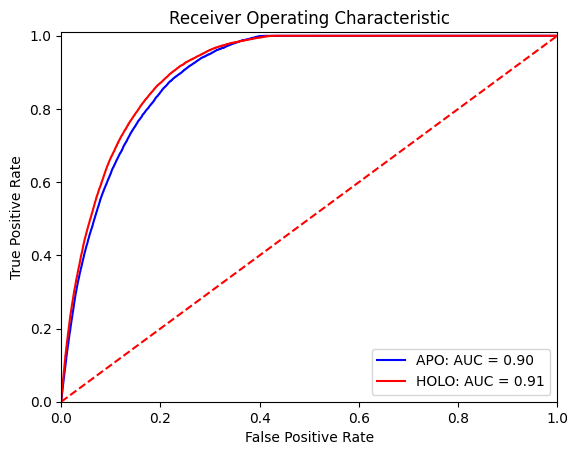

In [23]:
plt.title('Receiver Operating Characteristic')
plt.plot(fpr_apo, tpr_apo, 'b', label = 'APO: AUC = %0.2f' % roc_auc_apo)
plt.plot(fpr_holo, tpr_holo, 'r', label = 'HOLO: AUC = %0.2f' % roc_auc_holo)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
import sys
np.set_printoptions(threshold=sys.maxsize)
print(fpr_apo, tpr_apo, roc_auc_apo)

In [ ]:
print(fpr_holo, tpr_holo, roc_auc_holo)

# Train a classifier on APO sequences and evaluate on APO sequences

In [40]:
Xs_train_apo, Ys_train_apo = process_sequence_dataset(f'{DATA_PATH}/apo_train.txt', [ESM_EMBEDDINGS_PATH])
train_dataset_apo = SequenceCryptoBenchDataset(Xs_train_apo, Ys_train_apo)

Xs_test_apo, Ys_test_apo = process_sequence_dataset(f'{DATA_PATH}/apo_test.txt', [ESM_EMBEDDINGS_PATH])
test_dataset_apo = SequenceCryptoBenchDataset(Xs_test_apo, Ys_test_apo)

Class weights:  tensor([ 0.5235, 11.1424], device='cuda:0')
Epoch: 0 | Loss: 1.14441, Accuracy: 7.37% | Test loss: 2.69897, AUC: 0.525754813602736, MCC: -0.0021801873971183773, sum: 83926.0
Epoch: 1 | Loss: 0.90104, Accuracy: 80.78% | Test loss: 0.90949, AUC: 0.7499375250360191, MCC: 0.19332236964469618, sum: 16648.0
Epoch: 2 | Loss: 0.80937, Accuracy: 87.59% | Test loss: 0.84726, AUC: 0.7975823447076215, MCC: 0.2581538191392097, sum: 10437.0
Epoch: 3 | Loss: 0.76562, Accuracy: 85.41% | Test loss: 0.79720, AUC: 0.8113141148037286, MCC: 0.2760164640995806, sum: 13196.0
Epoch: 4 | Loss: 0.75890, Accuracy: 86.57% | Test loss: 0.78470, AUC: 0.8196548830628703, MCC: 0.29093376070322363, sum: 12167.0
Epoch: 5 | Loss: 0.69199, Accuracy: 86.61% | Test loss: 0.77233, AUC: 0.8264628710509002, MCC: 0.29816286041298046, sum: 12243.0
Epoch: 6 | Loss: 0.63809, Accuracy: 87.24% | Test loss: 0.76487, AUC: 0.8316499422316328, MCC: 0.30706341045606755, sum: 11684.0
Epoch: 7 | Loss: 0.64648, Accuracy: 86

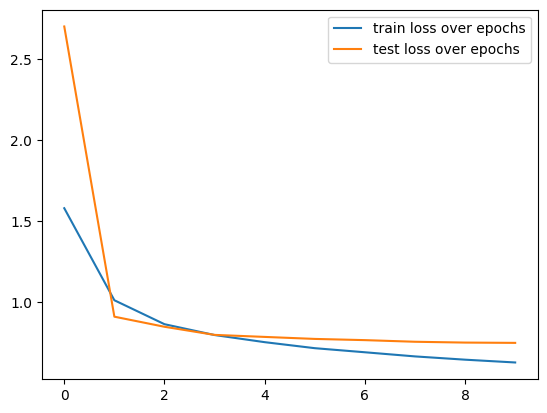

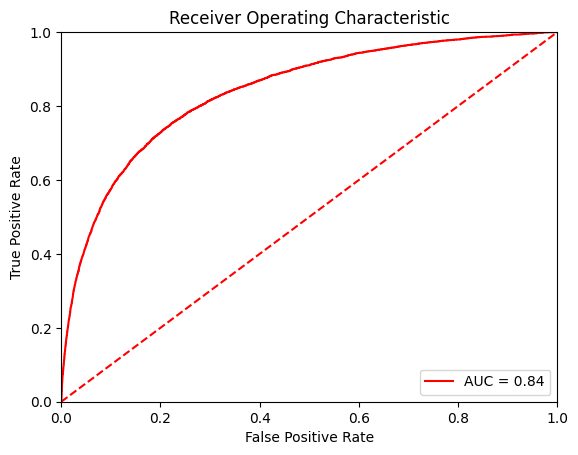

In [41]:
model_3 = CryptoBenchClassifier().to(device)
optimizer = torch.optim.Adam(params=model_3.parameters(),
                            lr=0.0001)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])


fpr_3, tpr_3, roc_auc_3 = train(model_3, optimizer, epochs=10, batch_size=16384, loss_fn=loss_fn, 
      train_dataset=train_dataset_apo, test_dataset=test_dataset_apo)

### Let's try merging both embeddings together (ESM2 + ProtBERT)

In [42]:
Xs_train_apo, Ys_train_apo = process_sequence_dataset(f'{DATA_PATH}/apo_train.txt', [ESM_EMBEDDINGS_PATH, PROTBERT_EMBEDDINGS_PATH])
train_dataset_apo = SequenceCryptoBenchDataset(Xs_train_apo, Ys_train_apo)

Xs_test_apo, Ys_test_apo = process_sequence_dataset(f'{DATA_PATH}/apo_test.txt', [ESM_EMBEDDINGS_PATH, PROTBERT_EMBEDDINGS_PATH])
test_dataset_apo = SequenceCryptoBenchDataset(Xs_test_apo, Ys_test_apo)

Class weights:  tensor([ 0.5235, 11.1424], device='cuda:0')
Epoch: 0 | Loss: 0.94175, Accuracy: 17.41% | Test loss: 1.63265, AUC: 0.5011733347959056, MCC: -0.009665021782772652, sum: 74144.0
Epoch: 1 | Loss: 0.84058, Accuracy: 83.58% | Test loss: 0.84428, AUC: 0.7786808280888177, MCC: 0.22815860380560374, sum: 14329.0
Epoch: 2 | Loss: 0.76680, Accuracy: 88.07% | Test loss: 0.80084, AUC: 0.8120108721877792, MCC: 0.28060237059446114, sum: 10266.0
Epoch: 3 | Loss: 0.69753, Accuracy: 88.09% | Test loss: 0.77608, AUC: 0.8253349938971861, MCC: 0.29975989650399437, sum: 10569.0
Epoch: 4 | Loss: 0.68999, Accuracy: 87.50% | Test loss: 0.75920, AUC: 0.8323080100666909, MCC: 0.30614230400113385, sum: 11363.0
Epoch: 5 | Loss: 0.64379, Accuracy: 88.00% | Test loss: 0.75246, AUC: 0.8370319128021692, MCC: 0.3174609318726641, sum: 10991.0
Epoch: 6 | Loss: 0.60555, Accuracy: 87.87% | Test loss: 0.74736, AUC: 0.8396653679560913, MCC: 0.3208706279921288, sum: 11201.0
Epoch: 7 | Loss: 0.60339, Accuracy: 8

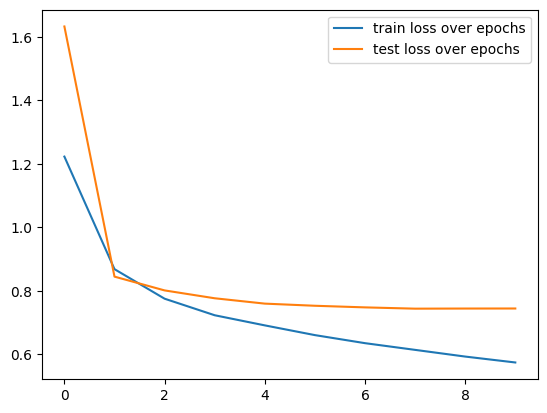

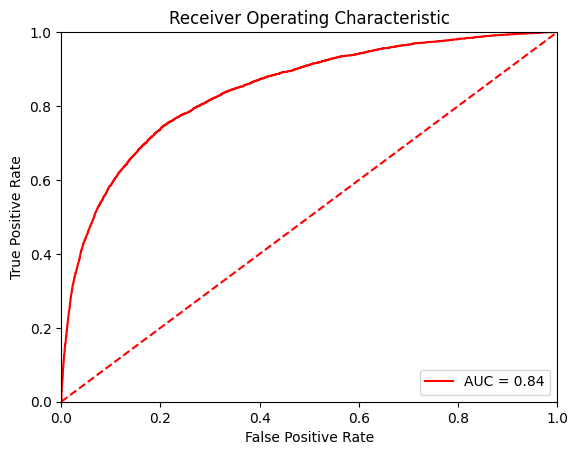

In [43]:
model_4 = CryptoBenchClassifier(ESM2_DIM + PROTBERT_DIM).to(device)
optimizer = torch.optim.Adam(params=model_4.parameters(),
                            lr=0.0001)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])


fpr_4, tpr_4, roc_auc_4 = train(model_4, optimizer, epochs=10, batch_size=16384, loss_fn=loss_fn, 
      train_dataset=train_dataset_apo, test_dataset=test_dataset_apo)

In [4]:
def enrich_data(dataset, path):
    new_dataset = {}
    for key, value in dataset.items():
        bfactors = []
        with open(f'{path}/{key}.txt') as f:
            lines = f.read()
            lines = lines.splitlines()
            for line in lines:  # iterate line by line
                bfactors.append(float(line))
        bfactors = np.array(bfactors)
        value = np.concatenate((value, np.array(bfactors)[:,None]),axis=1)
        new_dataset[key] = value
    return new_dataset


In [45]:
Xs_train_enriched = enrich_data(Xs_train_apo, '../data/apo-bfactors')
Xs_test_enriched = enrich_data(Xs_test_apo, '../data/apo-bfactors')

train_dataset_apo = SequenceCryptoBenchDataset(Xs_train_enriched, Ys_train_apo)
test_dataset_apo = SequenceCryptoBenchDataset(Xs_test_enriched, Ys_test_apo)

Class weights:  tensor([ 0.5235, 11.1424], device='cuda:0')
Epoch: 0 | Loss: 0.89675, Accuracy: 36.68% | Test loss: 1.25405, AUC: 0.4969739097345758, MCC: -0.005837609170726802, sum: 55627.0
Epoch: 1 | Loss: 0.74207, Accuracy: 85.71% | Test loss: 0.84025, AUC: 0.7802233694662466, MCC: 0.24492103063946571, sum: 12313.0
Epoch: 2 | Loss: 0.70515, Accuracy: 87.45% | Test loss: 0.79413, AUC: 0.8130455360658309, MCC: 0.2898109171023779, sum: 11138.0
Epoch: 3 | Loss: 0.72159, Accuracy: 87.92% | Test loss: 0.77308, AUC: 0.8266756669182486, MCC: 0.30767874220552516, sum: 10908.0
Epoch: 4 | Loss: 0.67639, Accuracy: 87.69% | Test loss: 0.75813, AUC: 0.8334734840182996, MCC: 0.3195399078042036, sum: 11388.0
Epoch: 5 | Loss: 0.62511, Accuracy: 87.51% | Test loss: 0.74804, AUC: 0.8384807521120836, MCC: 0.323551175310918, sum: 11667.0
Epoch: 6 | Loss: 0.63526, Accuracy: 87.31% | Test loss: 0.74124, AUC: 0.8418319197593511, MCC: 0.3271604841617245, sum: 11958.0
Epoch: 7 | Loss: 0.60523, Accuracy: 87.8

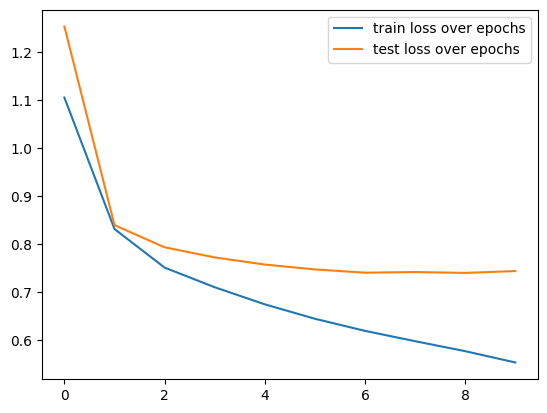

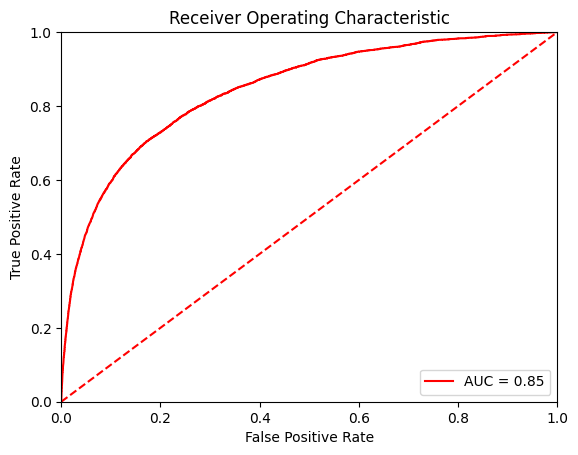

In [46]:
model_5 = CryptoBenchClassifier(ESM2_DIM + PROTBERT_DIM + 1).to(device)
optimizer = torch.optim.Adam(params=model_5.parameters(),
                            lr=0.0001)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

fpr_5, tpr_5, roc_auc_5 = train(model_5, optimizer, epochs=10, batch_size=16384, loss_fn=loss_fn, 
      train_dataset=train_dataset_apo, test_dataset=test_dataset_apo)

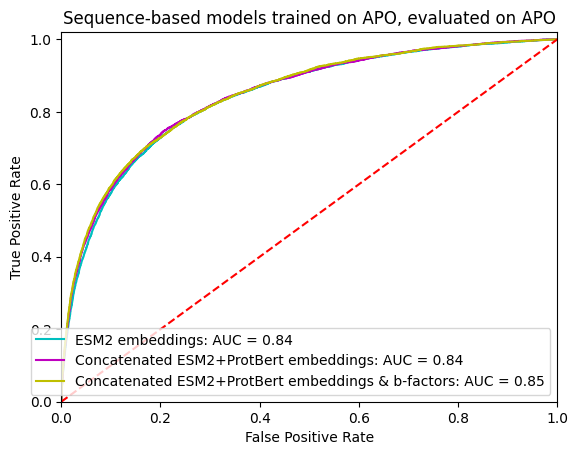

In [47]:
# TODO: print ROC curve merging the above graphs
plt.title('Sequence-based models trained on APO, evaluated on APO')
plt.plot(fpr_3, tpr_3, 'c', label = 'ESM2 embeddings: AUC = %0.2f' % roc_auc_3)
plt.plot(fpr_4, tpr_4, 'm', label = 'Concatenated ESM2+ProtBert embeddings: AUC = %0.2f' % roc_auc_4)
plt.plot(fpr_5, tpr_5, 'y', label = 'Concatenated ESM2+ProtBert embeddings & b-factors: AUC = %0.2f' % roc_auc_5)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1.02])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
print(fpr_3, tpr_3, roc_auc_3)

In [ ]:
print(fpr_4, tpr_4, roc_auc_4)


In [ ]:
print(fpr_5, tpr_5, roc_auc_5)

In [27]:
import csv

def enrich_data_with_rsa(dataset, path):
    new_dataset = {}
    error_count = 0
    for key, value in dataset.items():
        rsas = []
        if not os.path.isfile(f'{path}/{key[:4]}_{key[4:]}_results.txt'):
            rsas = np.empty(value.shape[0])
            rsas.fill(0.5)
            error_count += 1
        else:
            with open(f'{path}/{key[:4]}_{key[4:]}_results.txt', 'r') as f:
                print(f'processing {key} ...')
                csv_reader = csv.reader(f, delimiter='\t', quoting=csv.QUOTE_ALL)
                next(csv_reader)
                for row in csv_reader:
                    rsa = row[-1].split(' ')[-1]
                    if rsa == 'None':
                        rsas.append(0.5)
                    else:
                        rsas.append(float(rsa))
    
            rsas = np.array(rsas)
    
            if value.shape[0] != len(rsas):
                rsas = np.empty(value.shape[0])
                rsas.fill(0.5)
                error_count += 1

        value = np.concatenate((value, np.array(rsas)[:,None]),axis=1)
        new_dataset[key] = value
    print(error_count)
    return new_dataset


In [6]:
Xs_train_apo, Ys_train_apo = process_sequence_dataset(f'{DATA_PATH}/apo_train.txt', [ESM_EMBEDDINGS_PATH, PROTBERT_EMBEDDINGS_PATH])
Xs_test_apo, Ys_test_apo = process_sequence_dataset(f'{DATA_PATH}/apo_test.txt', [ESM_EMBEDDINGS_PATH, PROTBERT_EMBEDDINGS_PATH])

In [7]:
Xs_train_enriched = enrich_data(Xs_train_apo, '../data/apo-bfactors')
Xs_test_enriched = enrich_data(Xs_test_apo, '../data/apo-bfactors')

In [28]:
import os
Xs_train_enriched2 = enrich_data_with_rsa(Xs_train_enriched, '../data/apo-rsa')
Xs_test_enriched2 = enrich_data_with_rsa(Xs_test_enriched, '../data/apo-rsa')

processing 6aceA ...
processing 4do7A ...
processing 4ni8D ...
processing 6m53A ...
processing 3aexA ...
processing 2ig9C ...
processing 1p74A ...
processing 1b4kB ...
processing 7yikB ...
processing 8jyeA ...
processing 7q04E ...
processing 4glfA ...
processing 5uzvZ ...
processing 4oxfB ...
processing 4l85C ...
processing 1b00B ...
processing 7pa0B ...
processing 4cbeA ...
processing 2ofmX ...
processing 6vtgC ...
processing 7ec1B ...
processing 4k86A ...
processing 6fc2C ...
processing 3idhA ...
processing 3o80A ...
processing 4qs8A ...
processing 2q8uB ...
processing 7de1A ...
processing 5bqnA ...
processing 7by5A ...
processing 5l21A ...
processing 2b7cA ...
processing 3zvzB ...
processing 1nbfB ...
processing 2gk6B ...
processing 1g24C ...
processing 4mqeA ...
processing 1yfeA ...
processing 7pv7C ...
processing 6n5jB ...
processing 5gzzF ...
processing 2gmeB ...
processing 4pfsB ...
processing 3q4sA ...
processing 2z8zA ...
processing 3wr4A ...
processing 7rg8A ...
processing 5u

In [31]:
train_dataset_apo = SequenceCryptoBenchDataset(Xs_train_enriched2, Ys_train_apo)
test_dataset_apo = SequenceCryptoBenchDataset(Xs_test_enriched2, Ys_test_apo)

Processing 6aceA ...
Processing 4do7A ...
Processing 4ni8D ...
Processing 6m53A ...
Processing 3aexA ...
Processing 2ig9C ...
Processing 1p74A ...
Processing 1b4kB ...
Processing 7yikB ...
Processing 8jyeA ...
Processing 7q04E ...
Processing 4glfA ...
Processing 5uzvZ ...
Processing 4oxfB ...
Processing 4l85C ...
Processing 1b00B ...
Processing 7pa0B ...
Processing 4cbeA ...
Processing 2ofmX ...
Processing 6vtgC ...
Processing 7ec1B ...
Processing 4k86A ...
Processing 6fc2C ...
Processing 3idhA ...
Processing 3o80A ...
Processing 4qs8A ...
Processing 2q8uB ...
Processing 7de1A ...
Processing 5bqnA ...
Processing 7by5A ...
Processing 5l21A ...
Processing 2b7cA ...
Processing 3zvzB ...
Processing 1nbfB ...
Processing 2gk6B ...
Processing 1g24C ...
Processing 4mqeA ...
Processing 1yfeA ...
Processing 7pv7C ...
Processing 6n5jB ...
Processing 5gzzF ...
Processing 2gmeB ...
Processing 4pfsB ...
Processing 3q4sA ...
Processing 2z8zA ...
Processing 3wr4A ...
Processing 7rg8A ...
Processing 5u

In [33]:
_, y_train = train_dataset_apo[:]

np_list = []
for i in y_train:
    np_list.append(i.numpy().flatten())
    
y_train_concatenated = np.concatenate(np_list)

# compute class weights (because the dataset is heavily imbalanced)
class_weights = compute_class_weights(y_train_concatenated).to(device)

Class weights:  tensor([ 0.5235, 11.1424], device='cuda:0')
Epoch: 0 | Loss: 0.91364, Accuracy: 26.94% | Test loss: 1.34001, AUC: 0.5224682548641492, MCC: 0.006096638869823006, sum: 65234.0
Epoch: 1 | Loss: 0.75812, Accuracy: 83.46% | Test loss: 0.83908, AUC: 0.7816801888053205, MCC: 0.24016087266960398, sum: 14680.0
Epoch: 2 | Loss: 0.73157, Accuracy: 86.79% | Test loss: 0.79130, AUC: 0.8143588420998312, MCC: 0.285191730762885, sum: 11815.0
Epoch: 3 | Loss: 0.71115, Accuracy: 86.71% | Test loss: 0.76716, AUC: 0.8273521360925716, MCC: 0.29940871841643496, sum: 12158.0
Epoch: 4 | Loss: 0.66432, Accuracy: 87.49% | Test loss: 0.75507, AUC: 0.8347471738075232, MCC: 0.3126423695026753, sum: 11490.0
Epoch: 5 | Loss: 0.64664, Accuracy: 87.56% | Test loss: 0.74639, AUC: 0.8393986670520328, MCC: 0.3189605099735628, sum: 11524.0
Epoch: 6 | Loss: 0.65047, Accuracy: 87.22% | Test loss: 0.73770, AUC: 0.8428192806385775, MCC: 0.3229695030206642, sum: 11997.0
Epoch: 7 | Loss: 0.58836, Accuracy: 87.27

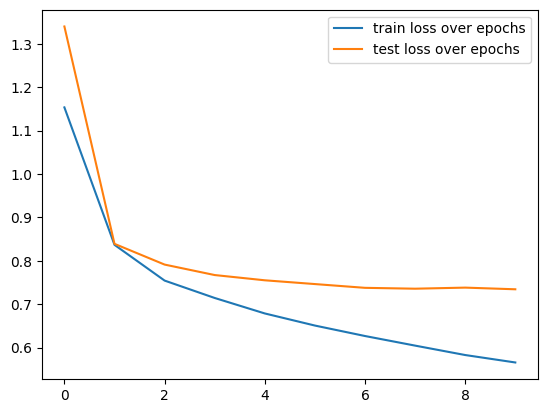

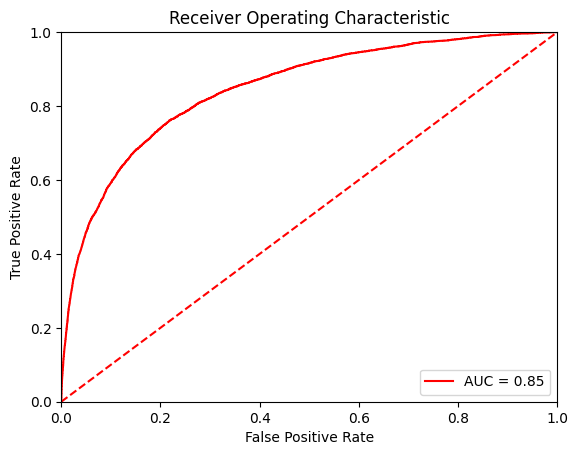

In [34]:
model_6 = CryptoBenchClassifier(ESM2_DIM + PROTBERT_DIM + 2).to(device)
optimizer = torch.optim.Adam(params=model_6.parameters(),
                            lr=0.0001)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=class_weights[1])

fpr_6, tpr_6, roc_auc_6 = train(model_6, optimizer, epochs=10, batch_size=16384, loss_fn=loss_fn, 
      train_dataset=train_dataset_apo, test_dataset=test_dataset_apo)